In [1098]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
from scipy import sparse

sys.path.insert(0, "../libs/network_embedding/")
import utils
from network_embedding import embedding, projection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [1099]:
journal_paper_table_file = "../data/nlm-journal-papers.csv"  # pd.read_csv()
citation_net_file = "../data/pmid-citation-net.npz"
date_file = "../data/pmid-disambiguated-date.csv"
journal_table_file = "../data/nlm-journal-table.csv"

In [1100]:
journal_table = pd.read_csv(journal_table_file)
journal_paper_table = pd.read_csv(journal_paper_table_file)
date_table = pd.read_csv(date_file)

display(journal_table.head())
display(journal_paper_table.head())
display(date_table.head())

,MeSH,nlm_journal_id,issn,journal_id,journal
0,Complementary Therapies,101761232,2662-7671,3675,BMC complementary medicine and therapies
1,Complementary Therapies,101761232,2662-7671,3675,BMC complementary medicine and therapies
2,Diagnostic Imaging,101762461,1573-4056,7834,Current medical imaging
3,Diagnostic Imaging,101762461,1573-4056,7835,Current medical imaging reviews
4,Face/surgery,101757922,2689-3622,10273,Facial plastic surgery & aesthetic medicine


,Unnamed: 0,journal_id,pmid
0,0,4051,2
1,1,4051,3
2,2,4051,4
3,3,4051,5
4,4,4051,6


,Unnamed: 0,pmid,pub_date,year,month,day
0,0,1,1975/6,1975.0,6.0,NaN
1,1,2,1975/10/27,1975.0,10.0,27.0
2,2,3,1975/10/27,1975.0,10.0,27.0
3,3,5,1975/10/27,1975.0,10.0,27.0
4,4,4,1975/10/27,1975.0,10.0,27.0


In [1101]:
A = sparse.load_npz(citation_net_file)
A.shape

(31985739, 31985739)

# Process

In [1102]:
Nr = jt["journal_id"].max() + 1
jt = journal_paper_table.copy()[journal_paper_table["pmid"] < Nc]
journalids, emb_journal_ids = np.unique(jt["journal_id"].values, return_inverse=True)
embjournal2journal_ids = journalids
jt["emb_journal_id"] = emb_journal_ids

In [1103]:
journal2embjournalid = dict(zip(journalids, np.arange(journalids.size)))
journal_table["emb_journal_id"] = journal_table["journal_id"].map(journal2embjournalid)
journal_table = journal_table.dropna()
journal_table["emb_journal_id"] = journal_table["emb_journal_id"].astype(int)
journal_table

,MeSH,nlm_journal_id,issn,journal_id,journal,emb_journal_id
3,Diagnostic Imaging,101762461,1573-4056,7835,Current medical imaging reviews,1298
6,Evidence-Based Medicine,101764819,2689-8381,14772,JBI evidence synthesis,2421
7,Evidence-Based Medicine,101764819,2689-8381,14772,JBI evidence synthesis,2421
17,Child Health,101771247,1428-345X,8521,Developmental period medicine,1456
18,Maternal Health,101771247,1428-345X,8521,Developmental period medicine,1456
...,...,...,...,...,...,...
27970,Medicine,370506,0002-9629,29037,The American journal of the medical sciences,4626
27971,Medicine,370506,1538-2990,29037,The American journal of the medical sciences,4626
27972,Medicine,302294,0140-6736,19292,"Lancet (London, England)",3289
27973,Medicine,302294,0140-6736,19292,"Lancet (London, England)",3289


### Construct a journal citation network

In [1104]:
Nc = A.shape[0]
Nr = jt["emb_journal_id"].max() + 1
journal2pmid = sparse.csr_matrix(
    (np.ones(jt.shape[0]), (jt["emb_journal_id"], jt["pmid"])), shape=(Nr, Nc)
)
A_journal = journal2pmid @ A @ journal2pmid.T

In [1105]:
jt["pmid"].drop_duplicates().shape

(22025499,)

In [1106]:
B = journal2pmid @ A
A_journal_bib = B @ B.T

In [1107]:
A_journal.shape

(5274, 5274)

### Embed the network using the DeepWalk based on a matrix decomposition

In [1108]:
vec = embedding.embed_network(A_journal.toarray(), window_length=10, dim=128)
# vec = embedding.embed_network(A_journal_bib.toarray(), window_length=10, dim=128)

In [1109]:
indeg = np.array(A_journal.sum(axis=0)).reshape(-1)

In [1110]:
top_freq_mesh = (
    journal_table.groupby("MeSH")
    .size()
    .reset_index()
    .rename(columns={0: "sz"})
    .sort_values(by="sz")
    .tail(12)
)
top_freq_mesh

,MeSH,sz
1987,Pharmacology,175
1798,Nursing,176
1749,Neurology,190
1684,Neoplasms,201
1572,Microbiology,203
2153,Public Health,205
478,Child,211
264,Biology,221
2236,Research,245
232,Biochemistry,285


In [1111]:
categories = [
    "Microbiology",
    "Molecular Biology",
    "Biochemistry",
    "Biology",
    "Science",
    "Pharmacology",
    "Research",
    "Neoplasms",
    "Medicine",
    "Public Health",
    "Child",
    "Nursing",
]
# categories = top_freq_mesh["MeSH"].values[::-1].tolist()

# Visualization

In [1112]:
marker_styles = ["h", "s", "<", "v", "^", "p", "X", "o", "D", ">"] + [
    "h",
    "s",
    "<",
    "v",
    "^",
    "p",
    "X",
    "o",
    "D",
    "+",
]

### Projection to 2D

In [1113]:
anchor_journal_table = (
    # journal_table.copy()[journal_table["MeSH"].apply(lambda x: x in top_freq_mesh["MeSH"].values)]
    journal_table.copy()[journal_table["MeSH"].apply(lambda x: x in categories)]
    .groupby("journal_id")
    .head(1)
    .reset_index()
)
anchor_journal_table

vec_2d = projection.get_semi_space(
    vec,
    vec[anchor_journal_table["emb_journal_id"], :],
    anchor_journal_table["MeSH"].values,
    dim=2,
    mode="lda",
)
# vec_2d[:, 0] *= -1

In [1114]:
#df = pd.merge(anchor_journal_table, pd.DataFrame({"ba":ba_vec, "emb_journal_id":np.arange(ba_vec.size)}), on = "emb_journal_id")
#df.groupby("MeSH").median().sort_values(by = "ba")

/home/skojaku/projects/graph-embedding-review-ja/notebook/utils.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_span, y_span = np.ptp(all_pos, axis=0)


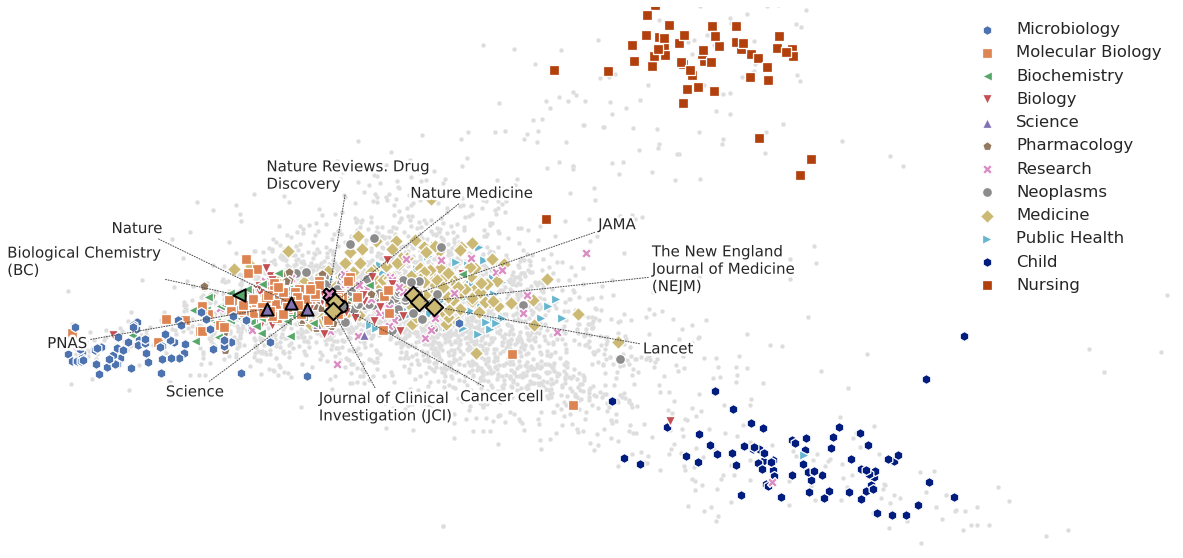

In [1115]:
# Plot
sns.set_style("white")
sns.set(font_scale=1.5)
sns.set_style("ticks")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
cmap = sns.color_palette().as_hex() + sns.color_palette("dark").as_hex()
cmap = dict(zip(categories, [cmap[i] for i in range(len(categories))]))

data_table = pd.DataFrame(
    {
        "x": vec_2d[:, 0],
        "y": vec_2d[:, 1],
        "deg": indeg,
        "emb_journal_id": np.arange(vec_2d.shape[0]),
    }
)
th = 0.001
xmin = np.quantile(data_table["x"], 0 * th)
xmax = np.quantile(data_table["x"], 1 - th)
ymin = np.quantile(data_table["y"], 1 * th)
ymax = np.quantile(data_table["y"], 1 - th)

ax = sns.scatterplot(
    data=data_table,
    x="x",
    y="y",
    color="#dddddd",
    s=20,
    # style=data_table["Region"].tolist(),
    # size=data_table["deg"].tolist(),
    # sizes=(5, 400),
    linewidth=0.1,
    ax=ax,
)

dg = pd.merge(anchor_journal_table, data_table, on="emb_journal_id")
# .reset_index()
# for i, (category, dg) in enumerate(anchor_journal_table.groupby("MeSH")):
#    dg = pd.merge(dg, data_table, on="emb_journal_id")
# dg["color"] = dg["MeSH"].map(cmap)
# print(dg["color"].tolist())
for i, category in enumerate(categories):
    dh = dg[dg.MeSH == category].reset_index()
    dh["m"] = marker_styles[i]
    ax.scatter(
        dh.x,
        dh.y,
        color=cmap[category],  # dg["color"].tolist(),
        # style = dg["MeSH"].tolist(),#dg["color"].tolist(),
        s=100,
        edgecolor="#fdfdfd",  # cmap[category],
        marker=marker_styles[i],
        linewidth=1.3,
        # alpha = 0.5,
        # size=dg["deg"].tolist(),
        # sizes=(5, 400),
        #    color=cmap[i],
        # style = "MeSH",
        # markers={category:marker_styles[i]},
        zorder=20 - i,
        label=category,
    )


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")
ax.legend(frameon=False)
# ax.legend().remove()

dg = pd.merge(dg, target_journal_table, on="emb_journal_id")
for i, category in enumerate(categories):
    dh = dg[dg.MeSH == category].reset_index()
    dh["m"] = marker_styles[i]
    ax.scatter(
        dh.x,
        dh.y,
        color=cmap[category],  # dg["color"].tolist(),
        # style = dg["MeSH"].tolist(),#dg["color"].tolist(),
        s=150,
        edgecolor="#000000",  # cmap[category],
        marker=marker_styles[i],
        linewidth=2,
        zorder=30,
    )
rename = {
    "Proceedings of the National Academy of Sciences of the United States of America": "PNAS",
    "Science (New York, N.Y.)": "Science",
    "Lancet (London, England)": "Lancet",
    "The Journal of clinical investigation": "Journal of Clinical Investigation (JCI)",
    "Biological chemistry": "Biological Chemistry (BC)",
    "The New England journal of medicine": "The New England Journal of Medicine (NEJM)",
    "Nature medicine": "Nature Medicine",
    "Canter cell": "Cancer Cell",
    "Nature reviews. Drug discovery": "Nature Reviews. Drug Discovery",
}
utils.repel_labels(
    ax,
    dg.x,
    dg.y,
    dg["journal_x"].apply(lambda x: rename.get(x, x)),
    fontsize=15,
    label_width=20,
    zorder=30,
    k=1.4,
)


fig.savefig("medical-journal-map", dpi=300, bbox_inches="tight")

# Find the translational axis

In [1116]:
ba_categories = ["Microbiology", "Nursing", "Child"]
rename_mesh = {"Microbiology": "basic", "Nursing": "applied", "Child": "applied"}
ba_anchor_journal_table = (
    journal_table.copy()[journal_table["MeSH"].apply(lambda x: x in ba_categories)]
    .groupby("journal_id")
    .head(1)
    .reset_index()
)
ba_anchor_journal_table["MeSH"] = ba_anchor_journal_table["MeSH"].map(rename_mesh)

display(ba_anchor_journal_table)
ba_vec = projection.get_semi_space(
    vec,
    vec[ba_anchor_journal_table["emb_journal_id"], :],
    ba_anchor_journal_table["MeSH"].values,
    dim=1,
    mode="lda",
    solver="eigen",
    shrinkage=0.5,
)
ba_vec = np.array(ba_vec).reshape(-1)

,index,MeSH,nlm_journal_id,issn,journal_id,journal,emb_journal_id
0,1209,applied,101584990,2162-2973,2670,Applied neuropsychology. Child,436
1,1402,applied,101586049,2048-7193,18503,Journal of the Pediatric Infectious Diseases S...,3182
2,1466,applied,101572033,2047-6310,23341,Pediatric obesity,3943
3,1654,basic,101585359,2235-2988,10785,Frontiers in cellular and infection microbiology,1865
4,1895,applied,101542497,2153-2168,6265,Childhood obesity (Print),1026
...,...,...,...,...,...,...,...
206,26563,applied,401075,0029-6554,22389,Nursing outlook,3784
207,26638,applied,376404,0029-6562,22396,Nursing research,3786
208,26872,basic,372370,0066-4227,2471,Annual review of microbiology,398
209,27270,basic,372625,0003-6072,2563,Antonie van Leeuwenhoek,424


In [1117]:
journal_table["emb_journal_id"]

3        1298
6        2421
7        2421
17       1456
18       1456
         ... 
27970    4626
27971    4626
27972    3289
27973    3289
27974    3289
Name: emb_journal_id, Length: 27951, dtype: int64

/home/skojaku/projects/graph-embedding-review-ja/notebook/utils.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_span, y_span = np.ptp(all_pos, axis=0)


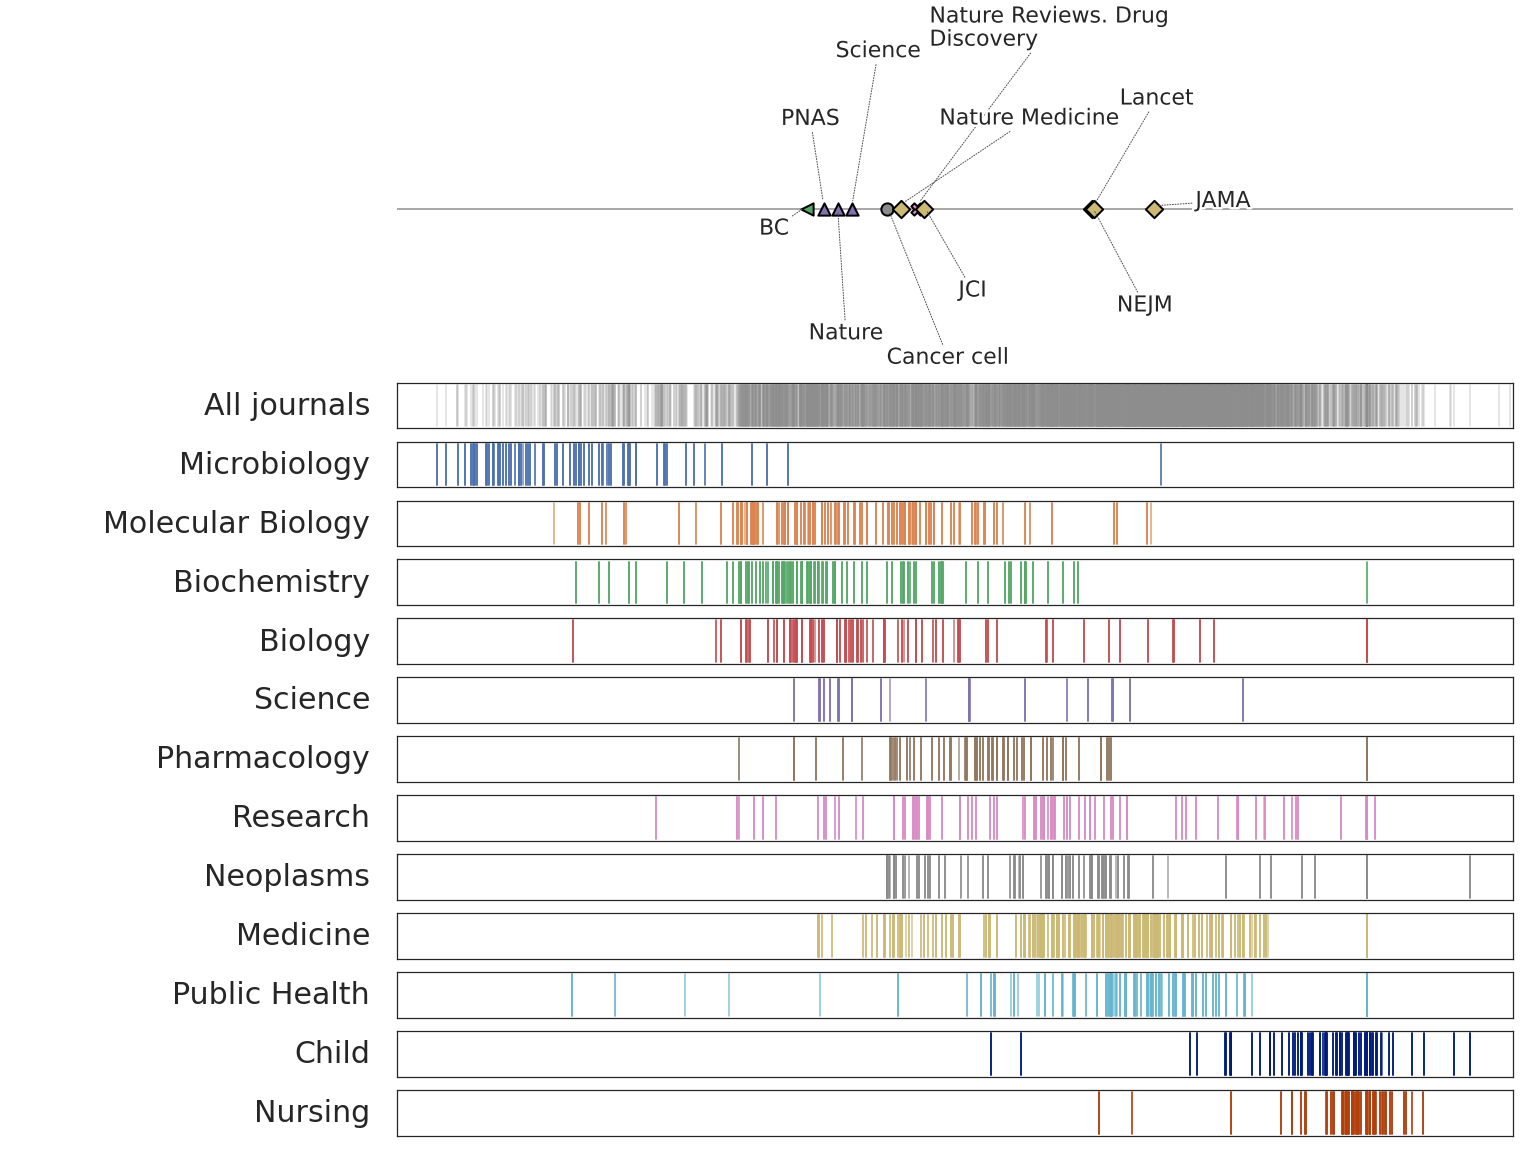

In [1124]:
import matplotlib.gridspec as gridspec

sns.set_style("white")
sns.set(font_scale=1.5)
sns.set_style("ticks")

# fig, axes = plt.subplots(
#    nrows=len(categories) + 2, ncols=1, figsize=(20, 20), sharex=True
# )
fig = plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(
    len(categories) + 2, 1, height_ratios=[7] + np.ones(len(categories) + 1).tolist()
)
axes = [fig.add_subplot(gs[i]) for i in range(len(categories) + 2)]

cmap = sns.color_palette().as_hex() + sns.color_palette("dark").as_hex()
cmap = dict(zip(categories, [cmap[i] for i in range(len(categories))]))

# Plot journal
# Plot journal
dg = pd.merge(
    anchor_journal_table,
    pd.DataFrame({"emb_journal_id": np.arange(ba_vec.size), "x": ba_vec}),
    on="emb_journal_id",
)
dg = pd.merge(dg, target_journal_table, on="emb_journal_id")
rename = {
    "Proceedings of the National Academy of Sciences of the United States of America": "PNAS",
    "Science (New York, N.Y.)": "Science",
    "Lancet (London, England)": "Lancet",
    "The Journal of clinical investigation": "JCI",
    "Biological chemistry": "BC",
    "The New England journal of medicine": "NEJM",
    "Nature medicine": "Nature Medicine",
    "Canter cell": "Cancer Cell",
    "Nature reviews. Drug discovery": "Nature Reviews. Drug Discovery",
}

xmin = -6
xmax = 6
# ax = sns.scatterplot(x = dg.x, y = 0.5, s = 200,  ax = axes[0])
ax = axes[0]
for i, category in enumerate(categories):
    dh = dg[dg.MeSH == category].reset_index()
    dh["m"] = marker_styles[i]
    ax.scatter(
        x=dh.x,
        y=np.ones(dh.x.size) * 0.5,
        color=cmap[category],  # dg["color"].tolist(),
        # style = dg["MeSH"].tolist(),#dg["color"].tolist(),
        s=150,
        edgecolor="#000000",  # cmap[category],
        marker=marker_styles[i],
        linewidth=2,
        zorder=1,
    )
ax.plot([xmin, xmax], [0.5, 0.5], color = "#8d8d8d", zorder =0)
utils.repel_labels(
    ax,
    dg.x,
    np.ones(dg.x.size) * 0.5 + 0.01 * np.random.rand(dg.x.size) + 0.005,
    dg["journal_x"].apply(lambda x: rename.get(x, x)),
    fontsize=22,
    label_width=25,
    zorder=1,
    k=0.26,
)
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 1)
ax.axis("off")
# f3_ax1 = fig3.add_subplot(gs[0, :])
# ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])

bins = 40
bins = np.linspace(np.min(ba_vec), np.max(ba_vec), bins)


barprops = dict(aspect="auto")
# cmap = sns.color_palette().as_hex()
# cmap = dict(zip(categories, [cmap[i] for i in range(len(categories))]))
ax = axes[1]
for j, h in enumerate(ba_vec):
    if j == 0:
        ax.plot(
            [h, h],
            [0, 1],
            alpha=0.3,
            color="#8d8d8d",
            label="All journals",
            linewidth=1.5,
        )
    else:
        ax.plot([h, h], [0, 1], alpha=0.3, color="#8d8d8d", linewidth=1.5)
    ax.set_xlim(xmin, xmax)
    ax.set_xticks([])

handles, labels = ax.get_legend_handles_labels()
for h in handles:
    h.set_linestyle("")

ax.legend(
    frameon=False, fontsize=30, loc="center right", bbox_to_anchor=(0, 0.5),
)
ax.set_xlim(xmin, xmax)
ax.set_yticks([])

for i, category in enumerate(categories):
    journal_ids = journal_table[journal_table["MeSH"] == category][
        "emb_journal_id"
    ].values
    hlist = ba_vec[journal_ids]
    ax = axes[i + 2]
    for j, h in enumerate(hlist):
        if j == 0:
            ax.plot([h, h], [0, 1], alpha=0.8, color=cmap[category], label=category)
        else:
            ax.plot([h, h], [0, 1], alpha=0.8, color=cmap[category])

    handles, labels = ax.get_legend_handles_labels()
    for h in handles:
        h.set_linestyle("")

    ax.legend(
        frameon=False, fontsize=30, loc="center right", bbox_to_anchor=(0, 0.5),
    )
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([])
    ax.set_xticks([])
fig.savefig("bench-to-bedside.pdf", bbox_inches="tight", dpi=300)

### Plot the citation map

In [1046]:
# q = 0.05
num_bins = 10

order = np.argsort(ba_vec)
rank = np.argsort(order)
rank = rank / rank.size

bins = np.linspace(0, 1, num_bins + 1)
# bins = np.linspace(np.quantile(ba_vec, q), np.quantile(ba_vec, 1 - q), num_bins)
ba_rank = np.maximum(0, np.floor( (rank-1e-2) / 0.1)).astype(int)
print(np.max(ba_rank))
num_journal = A_journal.shape[0]
U = sparse.csr_matrix(
    (np.ones_like(ba_rank), (np.arange(ba_rank.size), ba_rank)),
    shape=(num_journal, np.max(ba_rank) + 1),
)
A_ba = U.T @ A_journal @ U
A_ba = A_ba.toarray()

#sz = np.array(U.sum(axis=0)).reshape(-1)
#A_ba = np.diag(1 / np.maximum(sz, 1)) @ A_ba @ np.diag(1 / np.maximum(sz, 1))
# A_ba = A_ba - np.diag(np.diag(A_ba))

9


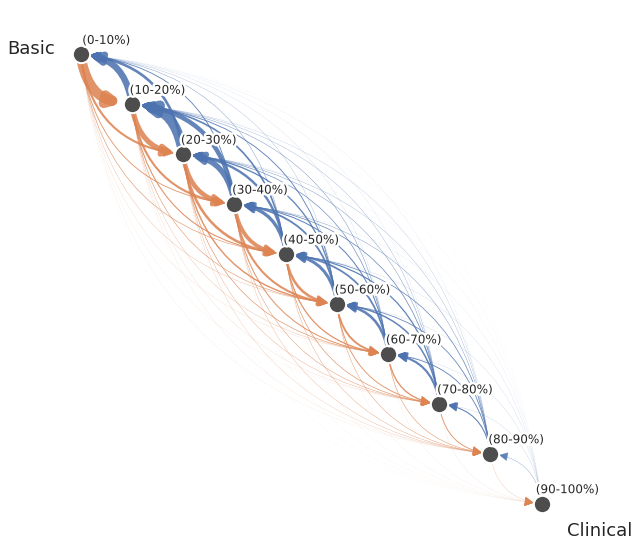

In [1095]:
# ax.scatter(np.arange(10), 10  - np.arange(10), s = 200, linewidth = 1, edgecolor = "black" )
import networkx as nx
import matplotlib.patheffects as PathEffects

sns.set_style("white")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 10))

connectionstyle = "arc3,rad=0.4"
#print(A_ba - np.diag(np.diag(A_ba)))
G = nx.from_numpy_array(A_ba - np.diag(np.diag(A_ba)), create_using=nx.DiGraph)
pos = {}
for i in range(10):
    pos[i] = (i, 10 - i)

cmap = sns.color_palette().as_hex()
nx.draw_networkx_nodes(
    G, pos=pos, node_color = "#4d4d4d", edgecolors="white", linewidths=2, ax=ax
)

width = np.array([d[2]["weight"] for d in G.edges(data=True)])
cols = np.array([ cmap[0]+"dd" if d[0] > d[1] else cmap[1]+"dd" for d in G.edges(data=True)])
width = 10 * np.maximum(0.0, np.power(width / np.max(width), 1))

nx.draw_networkx_edges(
    G,
    pos=pos,
    width=width,
    edge_color=cols,
    connectionstyle=connectionstyle,
    arrowstyle='-|>',
    arrowsize = 20,
    ax=ax,
)
for i in range(10):
    txt = ax.annotate("(%d-%d%%)" % (10 * i, 10 *(i+1)), xy=(i+0.5, 10 - i + 0.15), ha = "center", va = "bottom", fontsize = 12)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
ax.annotate("Clinical", xy=(9.5, 0.35), ha = "left")
ax.annotate("Basic", xy=(-0.5, 10), ha = "right")
ax.axis("off")
fig.savefig("ta-citation.png", dpi=300, bbox_inches="tight")

In [1096]:
print(np.sum(np.tril(A_ba, 1)) / np.sum(np.triu(A_ba,1)))
print(np.sum(np.tril(A_ba, 1)) )
print(np.sum(np.triu(A_ba,1)))


3.232452376366759
365898827.0
113195427.0


In [628]:
import numpy as np
import pandas as pd


def calc_exceeding_prob(x, y, sz_x, sz_y):
    """
    
    Calculate probability of x > y 

    
    Params
    ------
    x:np.array
        systemic risk
    y: np.array
        systemic risk
    sz_x: network size for x
    sz_y: netork size for y
    
    Return
    ------
    Probability of x > y
    
    """
    df = pd.concat(
        [
            pd.DataFrame({"v": x, "sz": sz_x, "g": np.zeros_like(x)}),
            pd.DataFrame({"v": y, "sz": sz_y, "g": np.ones_like(y)}),
        ],
        ignore_index=False,
    )

    numer = 0
    denom = 0
    for sz, dg in df.groupby("sz"):
        dgx = dg[dg.g == 0]
        dgy = dg[dg.g == 1]

        diff = np.add.outer(dgx["v"].values, -dgy["v"].values)
        numer += np.sum(diff > 0)
        denom += np.prod(diff.shape)
    return numer / np.maximum(1, denom)


x = np.random.rand(100)
y = np.random.rand(200) + 0.5
sz_x = np.random.randint(1, 10, x.size)
sz_y = np.random.randint(1, 10, y.size)
calc_exceeding_prob(x, y, sz_x, sz_y)

0.13956766917293234

In [ ]:
171, 231, 233, 545, 256, 687, 1798, 1006, 1008, 1405, 1558, 961, 1734, 1695, 1623, 1618, 1773, 1635